
##使用Metpy繪製近實時既GFS圖

## Installation

首先要install anaconda navigator
開啟Jupyter lab
安裝python
之後響cmd 果度打conda install ......
以下requirement 是需要的:
matplotlib
numpy
pandas
pint
pooch
pyproj
scipy
traitlets
xarray
cartopy
最重要係metpy

In [ ]:
#import python package
from datetime import datetime, timedelta

import urllib.request
import matplotlib.pyplot as plt

import xarray as xr
from metpy.calc import wind_components
import metpy.calc as mpcalc
from metpy.io import metar
from metpy.plots.declarative import (BarbPlot, ContourPlot, FilledContourPlot, MapPanel,
                                     PanelContainer, PlotObs)

from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from metpy.io import metar
from metpy.cbook import get_test_data

## 取得GFS data

GFS既data store 係一個DATABASE度，https://thredds.ucar.edu/thredds/catalog/idd/forecastModels.html
，而我地既目標係plot近實時既GFS圖，所以可以去呢個網址度搵下->Quarter degree forecast->最新既grib2 file->openDAP 2->然後就會見到一大堆GFS Dataset variable 會用到。我地既目標就係用python plot 呢d Dataset 既 variable。



In [ ]:
run_date = "20250225"#YYYYMMDD年月日
init = "1800"#時間,只可以0000,0600,1200或者1800
#url=f'https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_{run_date}_{init}.grib2'#Dataset既網址優先度第2
#GFS 0.25 resolution
url = f"http://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/GFS_Global_0p25deg_{run_date}_{init}.grib2"#Dataset既網址優先度第1
#GFS 1 resolution
#url=f"https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedegree_noaaport/GFS_Global_onedeg_noaaport_20240620_0600.grib2"
#舊版GFS
#url=f"https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_onedeg/GFS_Global_onedeg_20240621_0000.grib2"
#WW3（Wave watch 3)
#url=f"https://tds.scigw.unidata.ucar.edu/thredds/dodsC/grib/NCEP/WW3/Global/WW3_Global_{run_date}_{init}.grib2"
data = xr.open_dataset(url)#store 個dataset 做一個variable叫做data

In [ ]:
ds = data.metpy.sel(lat=slice(36, 7), lon=slice(100, 140))#選取要plot既範圍,呢個example既latitude係由北緯7-36N，東經100-140E

In [ ]:
#ds = data.metpy.sel(lat=slice(30, 0), lon=slice(360-100, 360-40))#呢個係西半球既例子

## Set Datetime

呢個係set個plot 既initial runtime and forecast hour


In [ ]:
plot_time = datetime(2025,2,25,18)+timedelta(hours=384)#例如呢個係plot 2025年2月24日18Z預測384小時後既GFS plot

## 計算風速
由於Thredds 既GFS dataset 係given 各種層面既u component 同v-component wind,所以要run mpcalc.wind_speed 去計算果個層面既實際風力
視乎需要去run.



In [ ]:
ds['wind_speed'] = mpcalc.wind_speed(ds['u-component_of_wind_height_above_ground'],
                                     ds['v-component_of_wind_height_above_ground'])#呢個就係計算10,20,30,40,50,80 同100米既風速,一般要30秒至2分鐘

In [ ]:
ds['wind_speed'] = mpcalc.wind_speed(ds['u-component_of_wind_isobaric'],
                                     ds['v-component_of_wind_isobaric'])#呢個係計算1000,975,950,925......isobaric level既風速,一般要load 10分鐘

## Plot 圖
cntr2即係解contour 2,cfill即係解contour fill, 可以set 其他名cntr3,cntr4,cfill3,cfill4又得，但你要在之後panel.plot度加返你想plot 既contour/contour fill variable.


我地要plot MSLP,10米風速顏色係matplotlib入面既gist_ncar

matplotlib 既cmap入面有好多種顏色，gist_ncar做風速顏色同nipy_spectral做溫度顏色係一流


In [ ]:
#今次例子：要MSLP,黑色線,linewidth=1,units係hPa,solid 線,contour scale 由850hPa去到1041hPa
cntr2 = ContourPlot()
cntr2.data = ds
cntr2.field = 'MSLP_Eta_model_reduction_msl'
cntr2.time = plot_time
cntr2.contours = list(range(850, 1041, 2))
cntr2.linecolor = 'black'
cntr2.linestyle = 'solid'
cntr2.linewidth = 1
cntr2.clabels = True
cntr2.plot_units='hPa'

In [ ]:
#備用
#cntr3=ContourPlot()
#cntr3.data = ds
#cntr3.field = 'Wind_speed_surface'
#cntr3.time = plot_time
#cntr3.contours = list(range(0,81,5))
#cntr3.linecolor = 'black'
#cntr3.linestyle = 'solid'
#cntr3.clabels = True
#cntr3.plot_units='knots'

In [ ]:
#備用，要風速contour 
#cntr4 = ContourPlot()
#cntr4.data = ds
#cntr4.field = 'wind_speed' 
#cntr4.time = plot_time
#cntr4.level=10*units.m
#cntr4.contours = list((range( 0,81,5)))
#cntr4.linecolor = 'red'
#cntr4.linestyle ='solid'
#cntr4.clabels=True
#cntr4.plot_units = 'knots'

In [ ]:
#備用,geopotential height
#cntr5 = ContourPlot()
#cntr5.data = ds
#cntr5.field = 'Geopotential_height_isobaric' 
#cntr5.time = plot_time
#cntr5.level=500*units.hPa
#cntr5.contours = list((range(5600,6000,20)))
#cntr5.linecolor = 'red'
#cntr5.linestyle ='solid'
#cntr5.clabels=True
#cntr5.plot_units = 'gpm'

然後plot contour fill



In [ ]:
#呢個例子就係contour filled,10m wind speed,knots 做單位, scale 係0-101knots，每5 knots一隻顏色，gist_ncar做色
cfill = FilledContourPlot()
cfill.data = ds
cfill.field = 'wind_speed' 
cfill.time = plot_time
cfill.level=10*units.m
cfill.contours = list((range( 0,101,5)))
cfill.image_range=(0,101)
cfill.colormap = 'gist_ncar'
cfill.colorbar = 'horizontal'
cfill.plot_units = 'knots'

In [ ]:
#備用contour filled, MSLP
#cfill = FilledContourPlot()
#cfill.data = ds
#cfill.field = 'MSLP_Eta_model_reduction_msl' 
#cfill.time = plot_time
#cfill.level=None
#cfill.contours = list((range( 850,1030,5)))
#cfill.image_range=(850,1030)
#cfill.colormap = 'gist_ncar'
#cfill.colorbar = 'horizontal'
#cfill.plot_units = 'hPa'

In [ ]:
#備用,可以吾run
#cfill = FilledContourPlot()
#cfill.data = ds
#cfill.field = 'Wind_speed_surface'
#cfill.colormap = 'gist_ncar'
#cfill.time=plot_time
#cfill.colorbar = 'horizontal'
#cfill.plot_units='knots'
#cfill.contours = list((range(0,81,5)))

In [ ]:
#備用
#cfill2=FilledContourPlot()
#cfill2.data=ds
#cfill2.field='Geopotential_height_isobaric'
#cfill2.contours = list((range( 5600,6000,20)))
#cfill2.time=plot_time
#cfill2.plot_units='gpm'
#cfill2.level=500*units.hPa
#cfill2.colormap='nipy_spectral'
#cfill2.colorbar='horizontal'

plot wind barbs or arrow



In [ ]:
#呢個例子plot 10米wind barbs,間距係5，5
barbs = BarbPlot()
barbs.data = ds
barbs.time = plot_time
#barbs.field=['u-component_of_wind_surface','v-component_of_wind_surface']
#barbs.field = ['u-component_of_wind_isobaric', 'v-component_of_wind_isobaric']
barbs.field=['u-component_of_wind_height_above_ground','v-component_of_wind_height_above_ground']
barbs.level = 10*units.m
barbs.skip = (5,5)
barbs.plot_units = 'knots'
barbs.color='red'

In [ ]:
# 呢個係個panel,contain所有要plot既element, 請記住panel area係西東南北，mer is mercator,state coastline borders為白色
#title 既128即係384除以3，np.min 同max以取得該圖既最高/最低值
#點解要乘3.6/1.852因為m/s轉knots
#panel.plots contain all element you want to plot
panel = MapPanel()
panel.area = [100,140,7,36]
panel.projection = 'mer'
panel.layers = ['states', 'coastline', 'borders']
panel.layers_edgecolor='white'
panel.title=f'GFS 0.25 resolution 10m wind speed with isobar at {plot_time} Z,{run_date}{init}Z run'"\n"f' Minimum pressure:{float(np.min(ds.MSLP_Eta_model_reduction_msl[128]/100))}hPa'"\n"f'Maximum 10m wind speed:{float(np.max(cfill.data.wind_speed[128]*3.6/1.852))}kts'"\n"f'Maximum 100m wind speed:{float(np.max(cfill.data.wind_speed[128][6]*3.6/1.852))}kts'"\n"f'Max surface wind gust:{float(np.max(ds.Wind_speed_gust_surface[128]*3.6/1.852))}kts'"\n"f'cheung chau 10m wind:{float(cfill.data.wind_speed[128][0][31][56]*3.6/1.852)}kts'
panel.plots=[cfill,cntr2,barbs]

In [ ]:
#pc.size 即係幅圖大小
pc = PanelContainer()
pc.size = (10,10)
pc.panels=[panel]

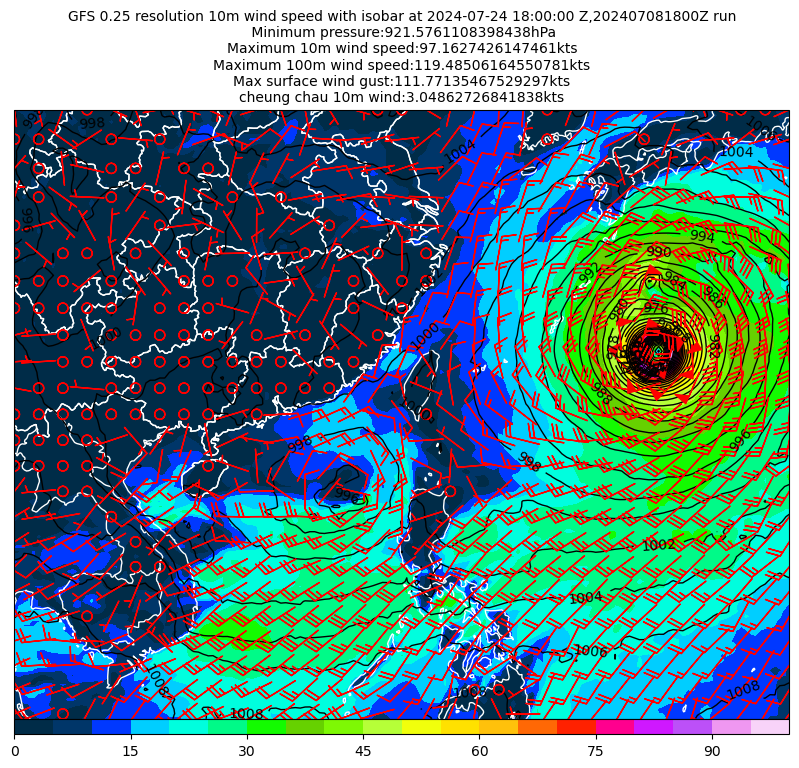

In [ ]:
pc.show()
#display 幅圖
#以下是2024年7月既例子